# Lecture 16: Ensemble Methods


Applied Machine Learning 


Professor: __Ramesh Natarajan__ \
Email: **ramesh.natarajan@yu.edu** \
Department of Computer Science \
Stern College and Yeshiva University

Date: Mar 20, 2024



## Acknowledgements

1. The starting point for developing the notebook-based instruction material was the set of notebooks provided by the previous  course instructor__[Prof. Zach Glassman](https://www.linkedin.com/in/zachary-glassman-7088844b/)__.
2. These notebooks have been augmented by similar instruction material taken from many, many other sources, including official documentation from many ML libraries and frameworks. I have adapted and modified the content where needed to make it compatible with student level, orientation and proficiency in this course.
3. The primary addition sources include:
   1. Course content from V. Kuleshov, Cornell Tech __[repo](https://github.com/kuleshov/cornell-cs5785-2020-applied-ml/blob/main/notebooks/lecture1-introduction.ipynb)__.
   2. Book and support material from Hal Daume II, __[A course in Machine Learning](http://ciml.info)__. __[repo](https://github.com/hal3/ciml/)__
   3. Book and support material from A. Geron, __[Hands-On Machine Learning with Scikit-Learn, Keras and Tensorflow (3rd edition)](https://homl.info/er3)__. __[repo](https://github.com/ageron/handson-ml3/blob/main/README.md)__




# Announcements

1. Problem Set 3 is due on Mar28  
2. Recitations will review Ensemble Methods




# Ensemble Methods 


<table>
    <td width="40%"><center>
        <img src="./img/Lecture-16/EnsembleMethods.png" /> 
    </center>
    Generated by Chat-GPT 
     </td>  
    <td>
<font size = "+1.2">
This chapter provides an overview of ensemble methods in machine learning. There are a variety of ensemble methods, which basically combine the results of multiple models in order to improve overall accuracy.

</td></table> 

For the ensemble methods to be effective, the individual models should be diverse - this diversity can be induced by either 

- using different classes of models on the same training dataset

- using the same model class with resampled versions of the training dataset.

The exact mechanism by which an ensemble model improves on the accuracy of the  individual constituent models may differ from case to case.  

There are numerous ensembling techniques such as Bagging, Boosting, Stacking, Random Forests and Mixture of Experts.  We will consider a few of these techniques in this lecture.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np

# Bagging 


<table>
    <td width="40%"><center>
        <img src="./img/Lecture-16/Bagging.png" /> 
        </center>
     </td>  
    <td>
<font size = "+1.0">
The key idea of *bagging* is to use  the ensemble-averaged prediction of a collection of `weak` learning models that are individually trained using training data obtained by sampling with replacement from the original training data set.

</td></table> 

 

A `weak learner` is a model with low complexity (very few parameters) whose  performance is therefore often just slightly better than random guessing (e.g. which is the prediction of the simplest model without any features).  

Some examples of weak learners are low-dimensional linear models, and decision trees with just 1 split (known as `stumps`).

The weak-learner models will individually exhibit very high variance when trained on the different versions/subsets of the training data.  The ensemble-averaging procedure, however, will lead to a  model with lower variance, and therefore to much more reliable prediction results.

For a data set $D$, the bagging procedure uses $M$ bootstrap-sampled training data sets $D_k$ which are of the same size as $D$, and obtained  by sampling with replacement from $D$ ($M$ is typically 100 or larger, so this approach is computationally intensive, but model training and inference are parallelizable).


Schematically

```python
for k in range(M):
    # collect a bootstrap-sampled data set and fit model on it
    X_k, y_k = sample_with_replacement(X, y)
    model_k = WeakLearnerModel().fit(X_k, y_k)
    ensemble.append(model_k)

# output average prediction at test time:
y_test = ensemble.average_prediction(X_test)
```

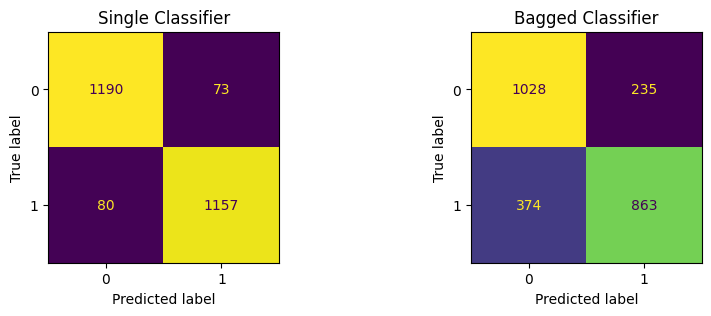

In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

# create a data set for comparing models
X, y = make_classification(n_samples=10000, n_features=10, n_informative=8)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# compare the Bagged Classifier versus a single Decision Tree Classifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ConfusionMatrixDisplay(confusion_matrix(y_test, 
                                        DecisionTreeClassifier()\
                                        .fit(X_train, y_train)\
                                        .predict(X_test)))\
                                        .plot(ax=ax[0], colorbar=False)
ConfusionMatrixDisplay(confusion_matrix(y_test, BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=300)\
                                        .fit(X_train, y_train)\
                                        .predict(X_test)))\
                                        .plot(ax=ax[1], colorbar=False);

ax[0].set_title("Single Classifier")
ax[1].set_title("Bagged Classifier")

plt.show()

## Properties of Bootstrap datasets

How similar are the individual bootstrap datasets?

For each dataset with $N$ examples, the probability of any example getting select is $1/N$ (for sampling with replacement).  Therefore the probability of not getting selected is $1-1/N$.  

Therefore, "How likely is it I could draw  $N$ examples and not select a given example?" - this is $(1-1/N)^N$, which for large $N$ is approximately  $1/e = 0.3679$.  

In summary, each bootstrapped sample will contain about 63.2% of the original examples, which is why this procedure is also known as the  $0.632$ bootstrap. 

Bagging or Bootstrap Aggregation reduces the model variance, and is therefore an alternative approach to regularization for improving model accuracy.



# Boosting 

<table>
    <td width="40%"><center>
        <img src="./img/Lecture-16/Boosting.png" /> 
        </center>
     </td>  
    <td>
<font size = "+1.0">
The key idea of *boosting* is to create a model ensemble in a sequential order, so that the later models can correct the prediction errors of the earlier models in the ensemble.


</td></table> 


If $f$ denotes the ensemble model, and  $g_t, t= 0, 1, \ldots, $ denotes the sequence of models added to the ensemble, then each $g_t$ is trained on a dataset which is obtained by weighted resampling of the training dataset, with greater weights being assigned to the examples which were misclassified by the earlier models in the ensemble.


Schematically,

1. Fit a weak learner $g_0$ on the data set $\mathcal{D} = \{(x^{(i)}, y^{(i)})\}$. Let $f=g_0$.

2. Compute weights $w^{(i)}$ for each $i$ based on model predictions $f(x^{(i)})$ and known targets $y^{(i)}$, so that more weight is given to the misclassified examples.

3. Fit the next weak learner $g_1$ on the data set $\mathcal{D}_1 = \{(x^{(i)}, y^{(i)})\}$ with weights $w^{(i)}$. (This can be by weighted resampling of the data, or by using a learning algorithm with a weighted loss function.

4. Set $f_1 = g_0 + \alpha_1 g_1$ for some  $\alpha_1$ (which is a stepwise learning rate parameter)

5. Go to Step 2 and repeat.

In Python-like pseudocode this looks as follows:

```python
weights_0 = np.ones(N,)
for k in range(n_models):
    model_k = SimpleBaseModel().fit(X, y, weights_k)
    predictions = model_k.predict(X)
    weights_k = update_weights(weights_k, predictions_k)
    ensemble = ensemble + alpha_k * model_k

# output consensus prediction at test time:
y_test = ensemble.consensus_prediction(X_test)
```

## Adaboost

One of the first practical boosting algorithms was called *Adaboost*, which is defined as follows:

We start with uniform weights $w^{(i)} = 1/N$ and $f = 0$. Then for $t=1,2,...,$:

1. Fit weak learner $g_t$ on $\mathcal{D}$ with weights $w^{(i)}$.

2. Compute misclassification error rate $e_t = \frac{\sum_{i=1}^n w^{(i)} \mathbb{I}\{y^{(i)} \neq f(x^{(i)})\}}{\sum_{i=1}^n w^{(i)}}$

3. Compute model learning rate parameter $\alpha_t = \log[(1-e_t)/e_t]$. Set $f \gets f + \alpha_t g_t$.

4. Compute new data weights $w^{(i)} \gets w^{(i)}\exp[\alpha_t \mathbb{I}\{y^{(i)} \neq f(x^{(i)})\} ]$.
   
6. Repeat until test set error of the ensemble model begins to increase.
7.  The ensemble model is given by $ f = g_0 + \sum_{i=1}^t \alpha_t g_t$

Let's implement Adaboost on a simple dataset to see what it can do.

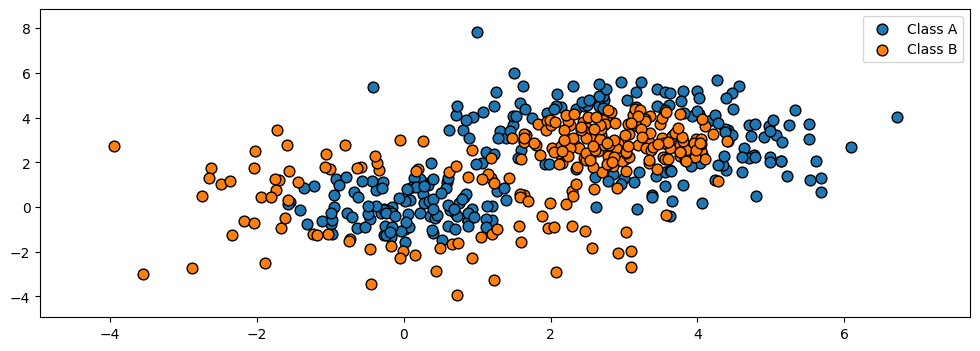

In [1]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_twoclass.html
import numpy as np
from sklearn.datasets import make_gaussian_quantiles

# Construct dataset
X1, y1 = make_gaussian_quantiles(cov=2., n_samples=200, n_features=2, n_classes=2, random_state=1)
X2, y2 = make_gaussian_quantiles(mean=(3, 3), cov=1.5, n_samples=300, n_features=2, n_classes=2, random_state=1)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, - y2 + 1))
import matplotlib.pyplot as plt

# Plot parameters

plt.rcParams['figure.figsize'] = [12, 4]
plot_colors, plot_step, class_names = "br", 0.02, "AB"
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

for i, n, c in zip(range(2), class_names, plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1],  s=60, edgecolor='k', label="Class %s" % n)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc='upper right')
plt.show()

Visualizing the output of the algorithm, we see that it can learn a highly non-linear decision boundary to separate the two classes.

/tmp/ipykernel_2018903/3299927711.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], cmap=plt.cm.Paired, s=60, edgecolor='k', label="Class %s" % n)


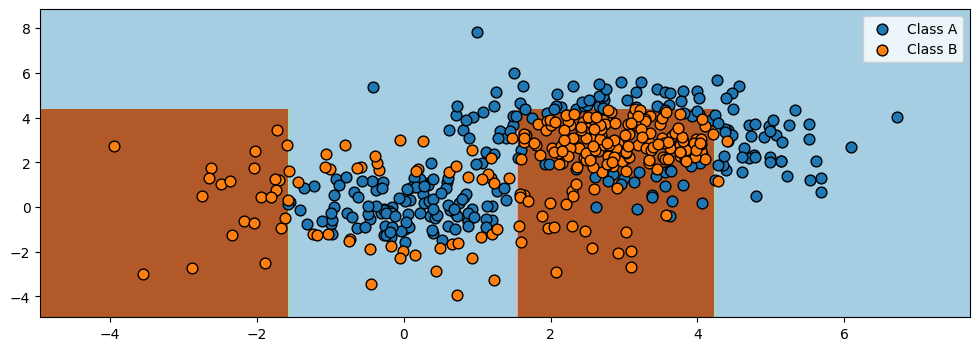

In [3]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Create and fit an AdaBoosted decision tree
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=5).fit(X, y)


xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step))

# plot decision boundary
Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

# plot training points
for i, n, c in zip(range(2), class_names, plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], cmap=plt.cm.Paired, s=60, edgecolor='k', label="Class %s" % n)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc='upper right')
plt.show()

# Gradient Boosting


Previously, we have seen that  a supervised learning algorithm consists of three components:
* A __model family__: the set of parameterized models within which we seek to obtain the optimal model (equivalently, the optimal  parameter set in a parameterized model family).
* An __objective function__ , which defines the accuracy of the model on the training and test data and is used to obtain the optimal model.
* An __optimizer__, which is an algorithmic technique (e.g. steepest descent) used to find the optimal model in the model class by optimizing to the objective function


Functional optimization offers a different angle on boosting algorithms and a recipe for new algorithms.

Consider a model class $f(x; \theta)$ where $f: \mathcal{X} \to \mathcal{Y}$ and $\theta$ is the set of model parameters, and the loss function $L(y, f(x; \theta))$.

Gradient boosting is a procedure that performs functional gradient descent with approximate gradients.

Start with $f_0(x) = 0$. Then, at each step $t= 0, 1, \ldots$:

1. Create a training dataset $\mathcal{D}_g$ and fit $g_t(x^{(i)})$ using loss $L_g$:
$$ g_t(x) \approx \frac{\partial L(y, f)}{\partial f} \bigg\rvert_{f = f_t(x)}.$$

2. Take a step of gradient descent using approximate gradients:
$$f_t(x) = f_{t-1}(x) - \alpha_t \cdot g_t(x).$$


Notice how after $T$ steps we get an additive model of the form
$$ f(x) = \sum_{t=1}^T \alpha_t g_t(x). $$
This looks like the output of a boosting algorithm!

This approach works for any differentiable loss function $L$ and hence it the loss function can be readily customized for any application.

# Losses for Gradient Boosting

Gradient boosting can optimize a wide range of losses.

1. Regression losses:
    * L2, L1, and Huber (L1/L2 interpolation) losses.
    * Quantile loss: estimates quantiles of distribution of $p(y|x)$.
2. Classification losses:
    * Log-loss, L2 loss, hinge loss, softmax loss, exponential loss, negative binomial likelihood, etc.
  
Some of these loss functions are illustrated below

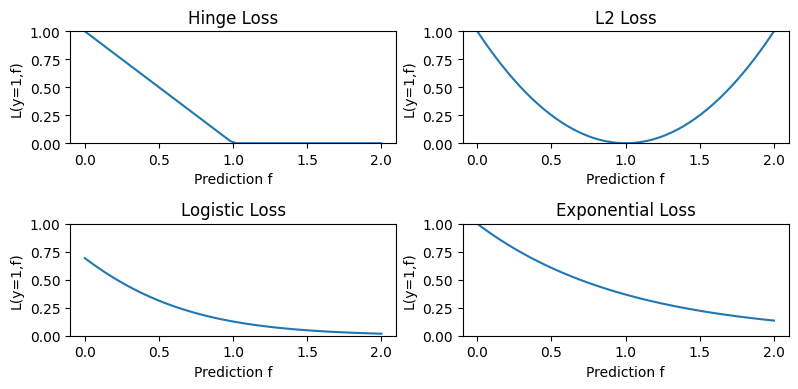

In [4]:
from matplotlib import pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [12, 4]

# define the losses for a target of y=1
losses = {
    'Hinge' : lambda f: np.maximum(1 - f, 0),
    'L2': lambda f: (1-f)**2,
    'Logistic': lambda f: np.log(1+np.exp(-2*f)),
    'Exponential': lambda f: np.exp(-f)
}

# plot them
f = np.linspace(0, 2)
fig, axes = plt.subplots(2,2, figsize=(8,4))
for ax, (name, loss) in zip(axes.flatten(), losses.items()):
    ax.plot(f, loss(f))
    ax.set_title('%s Loss' % name)
    ax.set_xlabel('Prediction f')
    ax.set_ylabel('L(y=1,f)')
    ax.set_ylim([0,1])
plt.tight_layout()

# Appendix
## Exponential Loss

Give a binary classification problem with labels $\mathcal{Y} = \{-1, +1\}$, the exponential loss is defined as

$$ L(y, f) = \exp(-y \cdot f). $$

* When $y=1$, $L$ is small when $f \to \infty$.
* When $y=-1$, $L$ is small when $f \to - \infty$.

With this loss function, the gradient boosting algorithm is essentially equivalend to Adaboost.

From there, we get that:
\begin{align*}
g_t & = \arg\min_{\phi} \sum_{i=1}^n w^{(i)} \mathbb{I}\{{y^{(i)} \neq g(x^{(i)}; \phi)}\} \\
\alpha_t & = \log[(1-e_t)/e_t]
\end{align*}
where $e_t = \frac{\sum_{i=1}^n w^{(i)} \mathbb{I}\{y^{(i)} \neq f(x^{(i)})\}}{\sum_{i=1}^n w^{(i)}\}}$.


## Squared Loss

Another popular choice of loss is the squared loss.
$$ L(y, f) = (y-f)^2. $$


The resulting algorithm is often called L2Boost. At step $t$ we minimize
$$\sum_{i=1}^n (r^{(i)}_t - g(x^{(i)}; \phi))^2, $$
where $r^{(i)}_t = y^{(i)} - f(x^{(i)})_{t-1}$ is the residual from the model at time $t-1$.

## Logistic Loss

Another common loss is the log-loss. When $\mathcal{Y}=\{-1,1\}$ it is defined as:

$$L(y, f) = \log(1+\exp(-2\cdot y\cdot f)).$$

This looks like the log of the exponential loss; it is less sensitive to outliers andit doesn't penalize large errors as much.

# Gradient Boosting: An Example

Let's now try running Gradient Boosted Decision Trees on a small regression dataset.

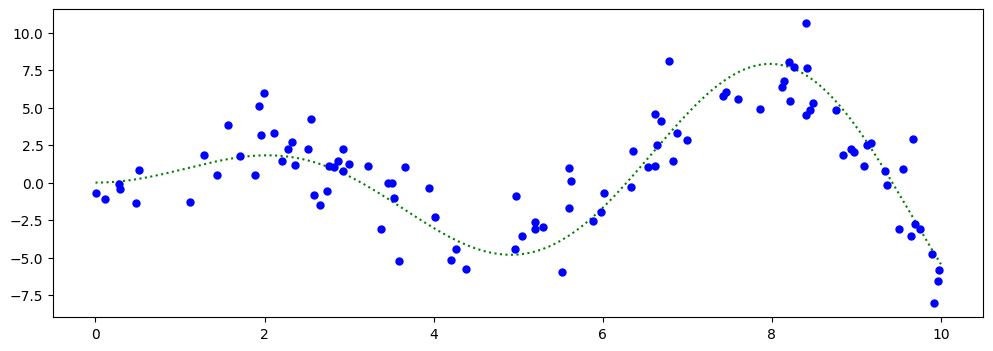

In [5]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html
X = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
X = X.astype(np.float32)

# Create dataset
f = lambda x: x * np.sin(x)
y = f(X).ravel()
dy = 1.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise

# Visualize it
xx = np.atleast_2d(np.linspace(0, 10, 1000)).T
plt.plot(xx, f(xx), 'g:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'b.', markersize=10, label=u'Observations')
plt.show()

Next, we train a GBDT regressor, and visualize its predictions

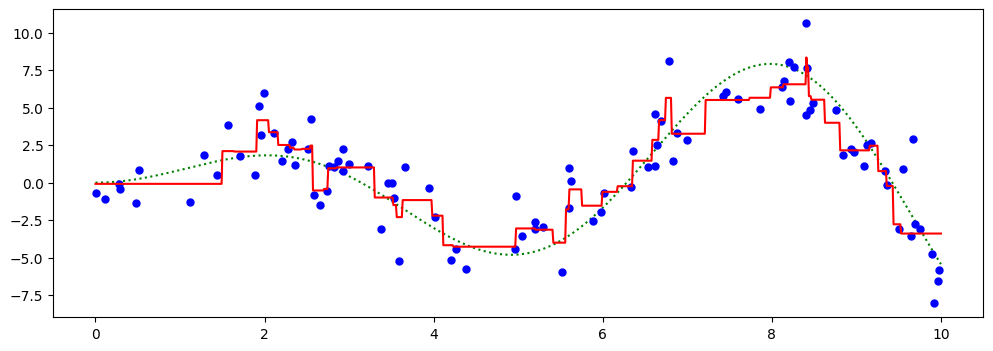

In [7]:
from sklearn.ensemble import GradientBoostingRegressor

learning_rate = 0.1
clf = GradientBoostingRegressor(loss='squared_error', learning_rate= learning_rate,
                                n_estimators=200, max_depth=3,
                                min_samples_leaf=9,
                                min_samples_split=9)
clf.fit(X, y)

y_pred = clf.predict(xx)
plt.plot(xx, f(xx), 'g:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'b.', markersize=10, label=u'Observations')
plt.plot(xx, y_pred, 'r-', label=u'Prediction')
plt.show()

# Practical Considerations

When using gradient boosting these additional facts are useful:
* We most often use small decision trees as the learner $g_t$, so that  input feature pre-processing is minimal.
* Regularization hyperparameters are the individual tree depths $T_D$ (typyically 1 or 2),  learning rate $\alpha$, and number of trees in the ensemble $T$. Optimal values for these are obtained by cross validation
* We can scale-up gradient boosting to big data by subsampling data at each iteration (a form of *stochastic* gradient descent).

# Summary of Gradient Boosting

Gradient boosted decision trees (GBTs) are one of the best off-the-shelf ML algorithms that exist, often on par with deep learning.
* Attain state-of-the-art performance. GBTs have won the most Kaggle competitions. 
* Require little data pre-processing and tuning.
* Work with any objective, including probabilistic ones.

Their main limitations are:
* GBTs not too well developed for text, images, audio.
* Can be used as an alternative to modern neural net models.